In [ ]:
! wget http://saliencydetection.net/duts/download/DUTS-TR.zip

In [ ]:
! unzip DUTS-TR.zip

In [ ]:
import cv2
import numpy as np
import copy
import tqdm
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
train_img = []
ground_truth = []
ssp_ground_truth = []
file_list1 = np.sort(os.listdir('/content/DUTS-TR/DUTS-TR-Image/'))
file_list2 = np.sort(os.listdir('/content/DUTS-TR/DUTS-TR-Mask/'))
for i in tqdm.tqdm(range(0, len(file_list1))):
    ground_truth.append(cv2.resize(cv2.imread('/content/DUTS-TR/DUTS-TR-Mask/' + file_list2[i], 0),(256,256)))
    train_img.append(cv2.resize(cv2.imread('/content/DUTS-TR/DUTS-TR-Image/' + file_list1[i], 1),(256,256)))

100%|██████████| 10553/10553 [00:33<00:00, 310.54it/s]


In [ ]:
len(ground_truth), len(train_img)

(10553, 10553)

In [ ]:
np.random.seed(0)
train_img = np.array(train_img)
ground_truth = np.array(ground_truth)
train_img = train_img.reshape((-1, 256, 256, 3))
ground_truth = ground_truth.reshape((-1, 256, 256, 1))

In [ ]:
def identity_block(inp, kernel_size, filters, name):
    norm_axis = 3
 
    out = tf.keras.layers.Conv2D(filters[0], (1, 1), use_bias=False)(inp)
    out = tf.keras.layers.BatchNormalization(axis=norm_axis)(out)
    out = tf.keras.layers.Activation('relu')(out)
 
    out = tf.keras.layers.Conv2D(filters[1], kernel_size, padding='same', use_bias=False)(out)
    out = tf.keras.layers.BatchNormalization(axis=norm_axis)(out)
    out = tf.keras.layers.Activation('relu')(out)
 
    out = tf.keras.layers.Conv2D(filters[2], (1, 1), use_bias=False)(out)
    out = tf.keras.layers.BatchNormalization(axis=norm_axis)(out)
    out = tf.keras.layers.add([out, inp])
    out = tf.keras.layers.Activation('relu', name=name)(out)
    
    return out

In [ ]:
def conv_block(inp, kernel_size, filters, strides=(2, 2)):
    norm_axis = 3
 
    out = tf.keras.layers.Conv2D(filters[0], (1, 1), use_bias=False)(inp)
    out = tf.keras.layers.BatchNormalization(axis=norm_axis)(out)
    out = tf.keras.layers.Activation('relu')(out)
 
    out = tf.keras.layers.Conv2D(filters[1], kernel_size, strides=strides, padding='same', use_bias=False)(out)
    out = tf.keras.layers.BatchNormalization(axis=norm_axis)(out)
    out = tf.keras.layers.Activation('relu')(out)
 
    out = tf.keras.layers.Conv2D(filters[2], (1, 1), use_bias=False)(out)
    out = tf.keras.layers.BatchNormalization(axis=norm_axis)(out)
    out = tf.keras.layers.Activation('relu')(out)
 
    shortcut = tf.keras.layers.Conv2D(filters[2], (1, 1), strides=strides, use_bias=False)(inp)
    shortcut = tf.keras.layers.BatchNormalization(axis=norm_axis)(shortcut)
    out = tf.keras.layers.add([out, shortcut])
    out = tf.keras.layers.Activation('relu')(out)
    
    return out

In [ ]:
def FRM_parallel_part_1(inp,filters=256):
    out = tf.keras.layers.Conv2D(filters, (1, 1), use_bias=False)(inp)
    out_1 = tf.keras.layers.Conv2D(filters/2, (1, 1), use_bias=False)(out)
    out_2 = tf.keras.layers.Conv2D(filters, (1, 1), use_bias=False)(out_1)
    return out_2


def FRM_parallel_part_2(inp,filters=256):
    return tf.keras.layers.Conv2D(filters,(1,1),use_bias=False)(inp)


def FRM(inp):
    output=FRM_parallel_part_1(inp)
    output=tf.keras.layers.Conv2D(64,(1,1),use_bias=False)(output)
    output=tf.image.resize(output,[64,64])
    return output


def ELM_foreground(isp):
    out = tf.keras.layers.Conv2D(320, (3,3), strides=(1,1), padding='same')(isp)
    return out


def ELM_background(isp):
    out = tf.keras.layers.Conv2D(320, (3,3), strides=(1,1), padding='same')(isp)
    return out


def ELM(inp,isp,reverse_isp):
    background=ELM_foreground(isp)
    background=tf.math.subtract(inp,background)
    foreground=ELM_background(reverse_isp)  
    foreground=tf.math.subtract(inp,foreground) 
    feature_subtraction=tf.math.subtract(foreground,background)
    output = tf.keras.layers.Conv2D(256, (1,1), strides=(1,1), activation='relu')(feature_subtraction)
    return output


def RFRM(inp):
    frm_1=FRM_parallel_part_1(inp)
    frm_2=FRM_parallel_part_2(inp)
    return tf.add(frm_1,frm_2)

def SSP(rfrm):
    output = tf.keras.layers.Conv2D(1, (3,3), strides=(1,1), activation='relu', padding='same')(rfrm)
    return output

In [ ]:
#GFRN

def gfrn(input_image, ssp_out):
    inp_image = tf.keras.layers.Conv2D(1, (3,3), strides=(1,1), activation='relu', padding='same')(input_image)
    G = tf.add(inp_image, ssp_out)

    return G

In [ ]:
norm_axis = 3
num_classes = 1000
input_shape = (256, 256, 3)


# Input
input_image = tf.keras.layers.Input(shape=input_shape) 


# Conv-1
out = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(input_image)
out = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', use_bias=False, name='conv1')(out)
out = tf.keras.layers.BatchNormalization(axis=norm_axis)(out)
conv_1_out = tf.keras.layers.Activation('relu', name='conv_1_out')(out)


# Res-2
out = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(conv_1_out)
out = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(out)
out = conv_block(out, 3, [64, 64, 256], strides=(1, 1))
out = identity_block(out, 3, [64, 64, 256], name ='res')
res_2_out = identity_block(out, 3, [64, 64, 256], name ='res_2_out')


# Res-3
out = conv_block(res_2_out, 3, [128, 128, 512])
out = identity_block(out, 3, [128, 128, 512], name ='resa')
out = identity_block(out, 3, [128, 128, 512], name ='ress')
res_3_out = identity_block(out, 3, [128, 128, 512], name ='res_3_out')


# Res-4
out = conv_block(res_3_out, 3, [256, 256, 1024])
for i in range(21):
    out = identity_block(out, 3, [256, 256, 1024], name ='res'+str(i))
res_4_out = identity_block(out, 3, [256, 256, 1024], name ='res_4_out')


# Res-5
out = conv_block(res_4_out, 3, [512, 512, 2048], strides=(1,1))
out = identity_block(out, 3, [512, 512, 2048], name ='resg')
res_5_out = identity_block(out, 3, [512, 512, 2048], name='res_5_out')


# ISP
out_4 = tf.keras.layers.Conv2D(256, (3,3), strides=(1,1), padding='same')(res_4_out)
out_4 = tf.keras.layers.Conv2D(256, (3,3), strides=(1,1), padding='same')(out_4)

out_5 = tf.keras.layers.Conv2D(256, (3,3), strides=(1,1), padding='same')(res_5_out)
out_5 = tf.keras.layers.Conv2D(256, (3,3), strides=(1,1), padding='same')(out_5)

out = tf.keras.layers.Conv2D(1, (3,3), strides=(1,1), padding='same')(out_5)
out = tf.keras.layers.Activation('relu')(out)
out = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='nearest')(out)
isp_out = tf.keras.layers.Activation('relu', name='isp_out')(out)

In [ ]:
#FRM 5 layers
frm_1=FRM(conv_1_out)
frm_2=FRM(res_2_out)
frm_3=FRM(res_3_out)
frm_4=FRM(res_4_out)
frm_5=FRM(res_5_out)

#ELM layer
elm_input=tf.concat([frm_1,frm_2,frm_3,frm_4,frm_5],3)
reverse_isp = 255 - isp_out
elm_output= ELM(elm_input,isp_out,isp_out)

#RFRM 1
rfrm_5 = RFRM(res_5_out)
rfrm_5 = tf.keras.layers.UpSampling2D(size=(4,4), interpolation='nearest')(rfrm_5)
ssp_1_inp=tf.add(rfrm_5,elm_output)
ssp_1_out = SSP(ssp_1_inp)
w1 = tf.Variable(np.random.rand(64,64), dtype='float32', trainable=True)
b1 = tf.Variable(np.random.rand(64,1), dtype='float32', trainable=True)
ssp_1_out = tf.add(tf.matmul(w1, ssp_1_out), b1)

#RFRM 2
rfrm_4= RFRM(res_4_out)
rfrm_4 = tf.keras.layers.UpSampling2D(size=(4,4), interpolation='nearest')(rfrm_4)
conc = tf.add(rfrm_4, elm_output)
ssp_2_inp=tf.concat([conc, ssp_1_out], 3)
ssp_2_out=SSP(ssp_2_inp)
w2 = tf.Variable(np.random.rand(64,64), dtype='float32', trainable=True)
b2 = tf.Variable(np.random.rand(64,1), dtype='float32', trainable=True)
ssp_2_out = tf.add(tf.matmul(w2, ssp_2_out), b2)

#RFRM 3
rfrm_3 = RFRM(res_3_out)
rfrm_3 = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='nearest')(rfrm_3)
conc_2 = tf.add(rfrm_3,elm_output)
ssp_3_inp=tf.concat([conc_2,ssp_2_out], 3)
ssp_3_out=SSP(ssp_3_inp)
w3 = tf.Variable(np.random.rand(64,64), dtype='float32', trainable=True)
b3 = tf.Variable(np.random.rand(64,1), dtype='float32', trainable=True)
ssp_3_out = tf.add(tf.matmul(w3, ssp_3_out), b3)

#RFRM 4
rfrm_2= RFRM(res_2_out)
conc_3 = tf.add(rfrm_5,elm_output)
ssp_4_inp=tf.concat([conc_3,ssp_3_out], 3)
ssp_4_out=SSP(ssp_4_inp)
w4 = tf.Variable(np.random.rand(64,64), dtype='float32', trainable=True)
b4 = tf.Variable(np.random.rand(64,1), dtype='float32', trainable=True)
ssp_4_out = tf.add(tf.matmul(w4, ssp_4_out), b4)

#FINAL SSP Outputs
ssp_out = out = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='nearest')(ssp_4_out)

#GFRN
output_saliency_map = gfrn(input_image, ssp_out)
A = tf.Variable(np.random.rand(256,256), dtype='float32', trainable=True)
b = tf.Variable(np.random.rand(256,1), dtype='float32', trainable=True)
output_saliency_map = tf.add(tf.matmul(A, G), b)


In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_img, ground_truth, test_size=0.2)

In [ ]:
val_y.shape, train_y.shape

((2111, 256, 256, 1), (8442, 256, 256, 1))

In [ ]:
ssp_ground_truth = np.array([cv2.resize(i, (64,64)) for i in train_y]).reshape(-1,64,64,1)
ssp_val_truth = np.array([cv2.resize(i, (64,64)) for i in val_y]).reshape(-1,64,64,1)

In [ ]:
ssp_ground_truth.shape, ssp_val_truth.shape

((8442, 64, 64, 1), (2111, 64, 64, 1))

In [ ]:
train_output_array = [ssp_ground_truth, ssp_ground_truth, ssp_ground_truth, train_y, train_y]
val_output_array = [ssp_val_truth, ssp_val_truth, ssp_val_truth, val_y, val_y]
output_array = [ssp_1_out, ssp_2_out, ssp_3_out, ssp_out, output_saliency_map]
loss_array = ['mse', 'mse', 'mse', 'mse', 'mse']

In [ ]:
# it = datagen.flow(train_x, train_output_array)
gen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
def gen_flow_for_two_inputs(X1, Y, c=1):
    genX1 = gen.flow(X1,Y[0],  batch_size=1)
    genX2 = gen.flow(X1,Y[1], batch_size=1)
    genX3 = gen.flow(X1,Y[2], batch_size=1)
    genX4 = gen.flow(X1,Y[3], batch_size=1)
    genX5 = gen.flow(X1,Y[4], batch_size=1)
    i=0
    while i<c:
            y1i = genX1.next()
            y2i = genX2.next()
            y3i = genX3.next()
            y4i = genX4.next()
            y5i = genX5.next()
            i+=1
            yield X1, [y1i, y2i, y3i, y4i, y5i]

gen_flow = gen_flow_for_two_inputs(train_x, train_output_array)

In [ ]:
model = tf.keras.Model(inputs=input_image, outputs=output_array)

In [ ]:
model.load_weights('drive/My Drive/weights.best.hdf5')

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(optimizer=opt, loss=loss_array)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='./weights.best.hdf5', 
                               verbose = 1, 
                               save_best_only = True)

In [ ]:
history = model.fit_generator(gen_flow, validation_data=(val_x, val_output_array), epochs=50, shuffle=True, callbacks = [checkpointer])

In [ ]:
! wget http://saliencydetection.net/duts/download/DUTS-TE.zip

In [ ]:
! unzip DUTS-TE.zip

In [ ]:
img = cv2.resize(cv2.imread('DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00003722.jpg', 1), (256,256))
img_g = cv2.resize(cv2.imread('DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00003722.png', 0), (256,256))

In [ ]:
pred = model.predict(img.reshape(-1,256,256,3))

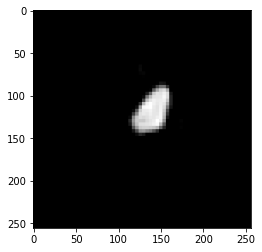

In [ ]:
plt.imshow(tf.squeeze(pred[-1][0]), cmap='gray')

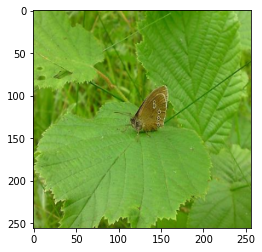

In [ ]:
plt.imshow(img[:,:,[2,1,0]])

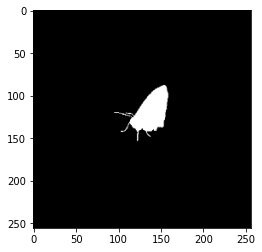

In [ ]:
plt.imshow(tf.squeeze(img_g), cmap='gray')